# River load sensor calibration

![](./images/station-hydrologique-digue.jpeg) 
Hydrological station located near La Digue on the Capesterre river © ObsEra.

The original version of this notebook was made by Antoine Lucas on top of the study made by Amande Roque-Bernard with the help of Gregory Sainton. In order to know more about the scientific context, please refer to Roque-Bernard et al. ([2023](https://doi.org/10.5194/esurf-11-363-2023)) _Phenomenological model of suspended sediment transport in a small catchment_, Earth Surface Dynamics, 11, 363–381. The dataset comes from [ObsEra](https://www.ozcar-ri.org/fr/observatoire-obsera/) (OBServatoire de l’Eau et de l’éRosion aux Antilles), an observatory located in Guadeloupe that gives us information on the erosion of this volcanic island in a few watersheds. With this notebook, you will learn how to prepare and clean a dataset.

The current notebook was edited in 2023 by Léonard Seydoux (seydoux@ipgp.fr) for the course _Earth Data Science_ at the [Institut de physique du globe de Paris](https://www.ipgp.fr/fr) (IPGP). If you have found a bug or have a suggestion, please feel free to contact me.

<img src="images/logo-obsera.png" style="margin:20px; height:100px;"/> <img src="images/logo-ipgp-upc.png" height=100 style="margin:20px; height:100px;"/>

## Instructions

This notebook contains a series of questions to which you should answer. Some example cells are given in the notebook to help you. You should not modify these cells. You can add as many cells as you want to answer the questions. You can also add markdown cells to explain your approach. 

## Prerequisites

Before running the notebook, you should make sure that the necessary packages are installed. You can do this by running the following cell. Be sure you are using a correct environment (check the top right corner of the notebook for the name of the environment). 

_Note that there is a blank line between the first import and the other ones. This is because we follow the [PEP8](https://www.python.org/dev/peps/pep-0008/) convention between standard library imports and third party imports._

In [2]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

## 1. Introduction

Estimating the suspended load within a river is a key issue in geomorphology. The suspended load is often estimated by sampling the water column and measuring the concentration $C_S$ of suspended particles. Although this method is accurate, it is not suitable for long-term monitoring, since it is time-consuming and expensive. A cheaper and faster method is to use turbidity probes. 

Turbidity probes allow to measure the turbidity $T$ of the water column, which is related to the concentration of suspended particles. However, the relationship between turbidity and suspended load is not straightforward. It depends on the size and the shape of the particles. The goal of this notebook is to calibrate a turbidity probe placed in a river against independent measurements of suspended load. In other terms, we want to find a relationship between the turbidity and the suspended load. And for this, we will use a machine-learning approach.

> __Question 1.__ What kind of machine learning problem is this? What is the input $x$, the output $y$? What are the features, the labels, what are the dimensions of the features and the labels spaces? 
>
> __Answer 1.__ This is a regression problem. This is the case because the input data is the turbidity and likely water level, which are both continuous quantities, and the output data to be predicted correctly is the concentration of suspended particles, which is also a continuous quantity. This defines a regression problem.

This notebook is mostly dedicated to the dataset preparation and cleaning. This is likely the most important part of the job. Then, you will play with your first models with the `scikit-learn` library. 

## 2. Suspended load measurements

The data for the calibration are stored under the [`./data`](./data) directory. The data are separated in two subsets, one with chemical information which contains the independent measurements of suspended load, and another one with hydrological information which contains the turbidity and water level measurements. 

### 2.1. Load the chemical data

The chemical data comes in a single CSV file located under the [`./data/chemistry`](./data/chemistry) repository. We here load it in a Pandas dataframe with the `pd.read_csv()` function. The goal of this first cell is to correctly parse the data, especially by converting the date and time information into `pd.Timestamp` objects and by selecting the column of interest. Note that the last statement of a Jupyter cell is automatically printed in a better format. 

> __Question 2.__ What is the `delimiter` keyword argument made for, and why did we set it to a semicolon `;` to load the data? How many rows do we have in this first dataset? And columns? 
>
> __Answer 2.__ The `delimiter` keyword argument is used to give the character for separating columns in a separated-values file. In the example below, the file uses a semicolumn `;` as a delimiter. The dataset contains 1318 rows and 22 columns (see the output of the cell below).

In [3]:
# Read it into a pandas dataframe
data_chemical_original = pd.read_csv(
    "./data/chemistry/CE_DIG_OBSERA_RIVERS_2019-09-26.csv",
    delimiter=";",
)

# Infer number of rows and columns
print(f"Number of rows: {data_chemical_original.shape[0]}")
print(f"Number of columns: {data_chemical_original.shape[1]}")

# Print the first 5 rows
data_chemical_original.head()

Number of rows: 1318
Number of columns: 22


,Date,Hour,Code Site,Site,Level,Type,Flask,Twater (°C),Suspended Load,pH,...,K,Mg,Ca,HCO3,Cl,SO4,Conductivity at 25°C,NICB (%),Comment,Validate
0,2019-09-20,10:53,GRCCEDIG,RCCEDIG,14.0,2,P,23.3,NaN,7.28,...,NaN,NaN,NaN,30.7,NaN,NaN,64.1,NaN,Alc. mesurée en labo le 20/09/2019; autres par...,NaN
1,2019-07-29,12:52,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,118.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28.1,NaN,P24,NaN
2,2019-07-28,20:22,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,17.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.7,NaN,P13,NaN
3,2019-07-28,18:51,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,38.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.3,NaN,P12,NaN
4,2019-07-28,18:36,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,48.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.4,NaN,P11,NaN


### 2.2. Turn the index into a datetime index

Note that pandas DataFrames have a special column called the index. You can see above that this column does not have any name and is used to uniquely identify each row of the DataFrame. By default, the index is a sequence of integers from $0$ to $N-1$, where $N$ is the number of rows in the DataFrame. You can also use the date and time information as the index of the DataFrame. This is useful when you want to select a subset of the data based on date and time information. The following cell shows how to do this. Check the new index column.

In [4]:
# Copy for safety
data_chemical_copy = data_chemical_original.copy()

# Merge the date and time columns together
date_and_time = data_chemical_copy["Date"] + " " + data_chemical_copy["Hour"]

# Convert the merge into a datetime column
data_chemical_copy["datetime"] = pd.to_datetime(date_and_time, format="mixed")

# Set the datetime column as the index
# The inplace=True keyword argument allows to replace the existing dataframe
data_chemical_copy.set_index("datetime", inplace=True)
data_chemical_copy.sort_index(inplace=True)

# Drop the old date and time columns from the oringal dataframe
data_chemical_copy.drop(["Date", "Hour"], axis=1, inplace=True)

# Check head
data_chemical_copy.head()

,Code Site,Site,Level,Type,Flask,Twater (°C),Suspended Load,pH,Conductivity,Na,K,Mg,Ca,HCO3,Cl,SO4,Conductivity at 25°C,NICB (%),Comment,Validate
datetime,,,,,,,,,,,,,,,,,,,,
2006-11-09 09:30:00,GRCCEDIG,RCCEDIG,15.0,2,P,22.2,NaN,7.43,NaN,5.2612,0.4442,1.2939,4.8087,25.52,4.9911,2.2282,55.5,-3.200518,NaN,NaN
2006-12-05 10:45:00,GRCCEDIG,RCCEDIG,97.0,2,P,21.4,161.2,6.51,NaN,2.5170,0.3257,0.3962,1.2793,4.94,3.2472,0.9795,22.2,9.945282,NaN,NaN
2006-12-08 10:00:00,GRCCEDIG,RCCEDIG,25.0,2,P,22.2,1.4,7.30,NaN,5.1830,0.5151,1.1061,3.7630,17.18,5.7392,1.8796,62.1,6.733688,NaN,NaN
2006-12-13 09:50:00,GRCCEDIG,RCCEDIG,28.0,2,P,21.5,NaN,7.42,NaN,5.3743,0.5223,1.1815,4.2852,26.79,5.6854,2.1321,49.4,-15.340436,NaN,NaN
2006-12-15 10:20:00,GRCCEDIG,RCCEDIG,64.0,2,P,21.2,NaN,6.82,NaN,3.2850,0.3419,0.5086,1.5788,6.79,4.0292,1.0698,24.2,9.206315,NaN,NaN


### 2.3. Select the suspended load column

Finally, we extract the data of interest here, a.k.a. the suspended load measurements. Note that since this is only a single column from the `data_chemical_copy` DataFrame, the result is a pandas Series.

In [5]:
# Extract the suspended load
suspended_load = data_chemical_copy["Suspended Load"]

# Drop the NaN values
suspended_load.dropna(inplace=True)

# Print the first few rows
suspended_load.head()

datetime
2006-12-05 10:45:00    161.2
2006-12-08 10:00:00      1.4
2007-03-06 09:30:00     19.2
2007-03-07 14:30:00     11.3
2007-03-12 10:30:00     29.2
Name: Suspended Load, dtype: float64

Pandas is a very handy library to inspect and manipulate data. You can find more information about it in the [documentation](https://pandas.pydata.org/pandas-docs/stable/). For instance, some high-level methods allow you to quickly inspect the data. For instance, the `describe()` method gives you a summary of the data. The `plot()` method allows you to quickly plot the data. You can also use the `head()` and `tail()` methods to inspect the first and last rows of the DataFrame. 

> __Question 3.__ Can you give a high-level definition of what an object is in Python? This definition should include the notion of _attributes_ and _methods_. According to this definition, what is a DataFrame, and what does the `info()` instruction do?
> 
> __Answer 3.__ An object is a data structure that contains attributes and methods. An attribute is a variable that belongs to the object, and a method is a function that belongs to the object. A DataFrame is an object that contains data in a tabular form. The `info()` instruction gives information about the DataFrame, such as the number of rows and columns, the type of each column, and the memory usage.

count     340.000000
mean      121.640176
std       206.564466
min         0.300000
25%        16.700000
50%        55.750000
75%       147.500000
max      1702.000000
Name: Suspended Load, dtype: float64

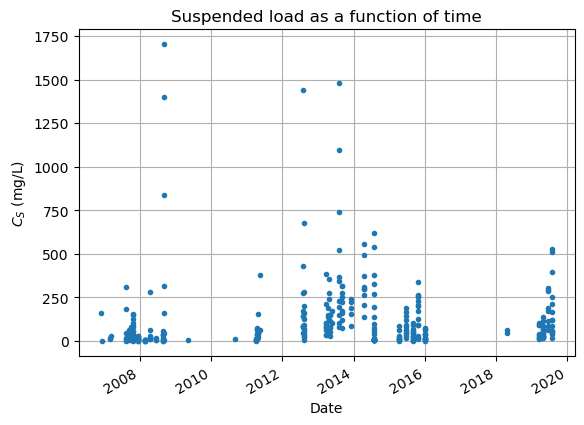

In [6]:
# Plot
suspended_load.plot(
    style=".",
    xlabel="Date",
    ylabel="$C_S$ (mg/L)",
    grid=True,
    title="Suspended load as a function of time",
)

# Describe the data
suspended_load.describe()

## 3. Hydrological data

Your turn now! In this part, we will deal with the hydrological data. The ultimate goal of this practical is to use some of the hydrological data to predict the suspended load data. Thus, we need to load the hydrological data into a dataframe. Note that the hydrological data are split into different files. We thus first need to load all the files individually with the `pd.read_csv()` function, and then concatenate them into a single DataFrame with the `pd.concat()` function.

First, in order to list all hydrological, you can make use of the `glob.glob()` method.

Then, note that the hydrological data contains non-numeric values (missing samples), that have either been replaced in the file by the values -30000.0, NAN or 1e+10 (why would you like something simple?). We will have to deal with these missing values. For that, you can use the `na_values` keyword argument of the `pd.read_csv()` function. Please, check the documentation of this function to see how to use it. For convenience, you can also parse the dates automatically with the `parse_dates` keyword argument. In general, checking the documentation of `pd.read_csv()` is very instructive. You can find it [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).

> __Question 4.__ Load the hydrological data into a single DataFrame. Similarly to the chemical data, you should use the date and time information as the index of the DataFrame. What relevant information do you think you should extract from the hydrological data to perform the calibration? Plot one of them as a function of time.
> 
> __Answer 4.__ The relevant information to extract from the hydrological data is the turbidity and the water level. These are the two variables that are likely to influence the concentration of suspended particles.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732981 entries, 2012-05-18 08:30:00 to 2019-07-25 10:15:00
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   level      722105 non-null  float64
 1   turbidity  547116 non-null  float64
dtypes: float64(2)
memory usage: 16.8 MB


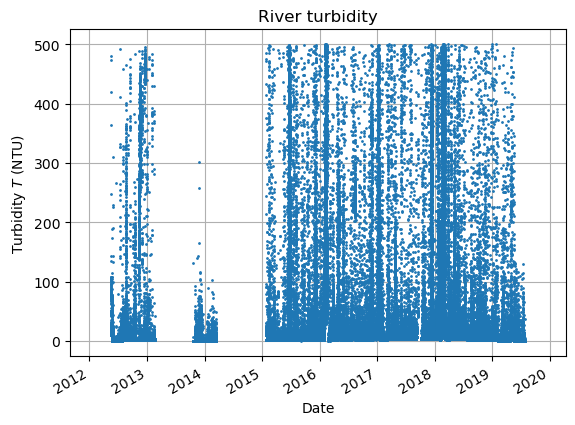

In [7]:

# Initialize the list of dataframes for the hydro dataset
filepaths = glob("data/hydrology/*.csv")

# Initialize an empty list to store the dataframes
data_hydro = []

# Define the options for reading the CSV files
read_options = {
    "sep": ",",
    "na_values": {"-30000.0", "NAN", "1e+10"},
    "comment": "#",
    "parse_dates": ["datetime"],
}

# Get the data from each file, append to the list, and concatenate
data_hydro = pd.concat([pd.read_csv(f, **read_options) for f in filepaths])

# Set the datetime column as the index, and sort the index
data_hydro.set_index("datetime", inplace=True)
data_hydro.sort_index(inplace=True)

# Select interesting columns
data_hydro = data_hydro[["level", "turbidity"]]

# Print info
ax = data_hydro["turbidity"].plot(
    xlabel="Date",
    ylabel="Turbidity $T$ (NTU)",
    grid=True,
    style=".",
    ms=2,
    rasterized=True,
    title="River turbidity",
)

# Add margins to see the labels better
ax.margins(x=0.1)

data_hydro.info()

## 4. Prepare and inspect the data

### 4.1. Synchronize the data

You may have realized that the chemical and hydrological data are not synchronized. Actually, the chemical data is sparse in time, whereas the hydrological data is (more or less) continuous with a minimum of 1 measurement every 5 minutes. We will have to synchronize the data to be able to compare them.

> __Question 5.__ Resample the hydrological data to match the chemical data. You can use the `pd.DataFrame.resample()` method in order to do this. Take the time to read the documentation of this method, and to see implemented examples on the web.
>
> __Answer 5.__ See the code below.

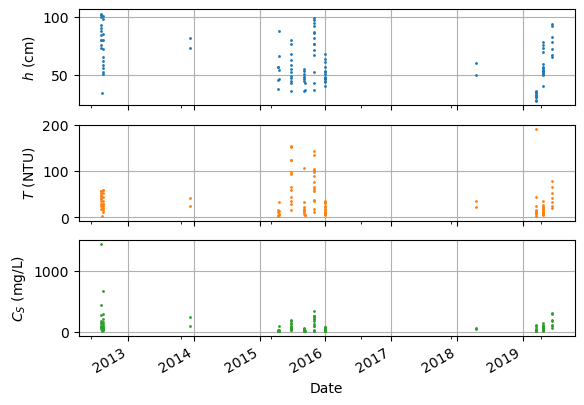

In [8]:
# Get the minimum common start and end dates
start = max(suspended_load.index.min(), data_hydro.index.min())
end = min(suspended_load.index.max(), data_hydro.index.max())

# Trucate the dataframes
suspended_load = suspended_load.truncate(before=start, after=end)
data_hydro_resampled = data_hydro.truncate(before=start, after=end).copy()

# Interpolate on a fine time grid and reindex on the most constraining index
data_hydro_resampled = data_hydro_resampled.resample("1min")
data_hydro_resampled = data_hydro_resampled.interpolate(method="linear", limit=10)

# Reindex
data_hydro_resampled = data_hydro_resampled.reindex(suspended_load.index)

# Gather the data in a single dataframe
data = data_hydro_resampled.copy()
data["suspended_load"] = suspended_load
data.dropna(inplace=True)

# Plot the data
ax = data.plot(
    subplots=True,
    style=".",
    grid=True,
    xlabel="Date",
    legend=False,
    ms=2,
);

# Labels
ax[0].set_ylabel("$h$ (cm)")
ax[1].set_ylabel("$T$ (NTU)")
ax[2].set_ylabel("$C_S$ (mg/L)");

### 4.2. Inspect the dataset

Now we can start to investigate correlations between the turbidity and the suspended load. We will start by plotting the data. We will also compute the correlation coefficient between the turbidity and the suspended load. The goal here is to get a first idea of the relationship between the turbidity and the suspended load. 

> __Question 6.__ Using the `pd.plotting.scatter_matrix()` function, inspect the relationship between the turbidity, water level and suspended load. What do you observe? Does the correlation coefficient give you a good idea of the relationship between the turbidity and the suspended load? 
> 
> __Answer 6.__ The scatter matrix shows that the turbidity and the suspended load are correlated. We see that there might be a linear relationship between the two variables. We also see that the water level also somewhat correlates with the suspended load. The correlation coefficient of the turbity and the suspended load is lower than the one with the water level. This is because the turbidity is not the only factor influencing the suspended load.

Correlation coefficients
                   level  turbidity  suspended_load
level           1.000000   0.381636        0.627384
turbidity       0.381636   1.000000        0.322605
suspended_load  0.627384   0.322605        1.000000


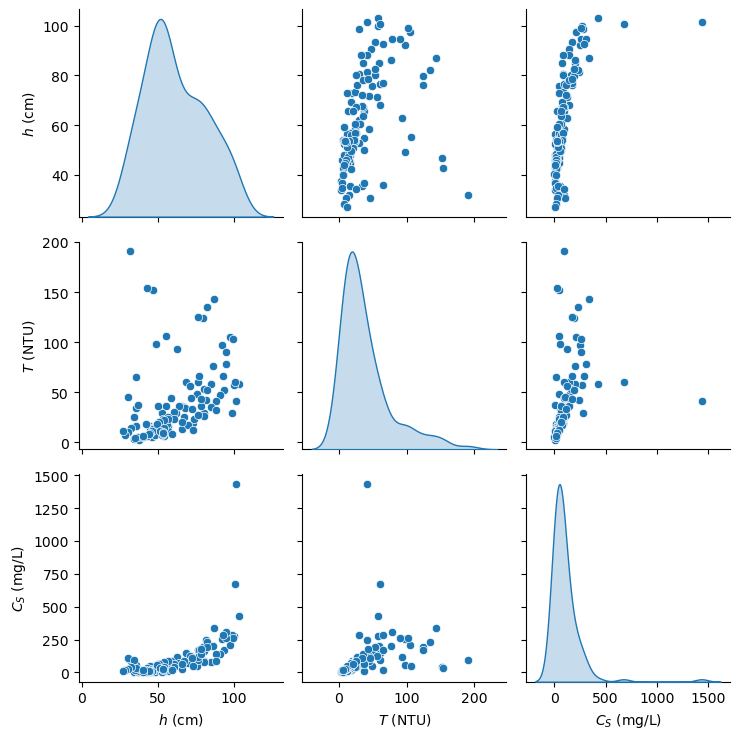

In [9]:
# Scatter matrix
pairplot = sns.pairplot(data, kind="scatter", diag_kind="kde")

# Correlation coefficients
print("Correlation coefficients")
print(data.corr())

# Labels
ax = pairplot.axes
ax[0, 0].set_ylabel("$h$ (cm)")
ax[1, 0].set_ylabel("$T$ (NTU)")
ax[2, 0].set_ylabel("$C_S$ (mg/L)")
ax[2, 0].set_xlabel("$h$ (cm)")
ax[2, 1].set_xlabel("$T$ (NTU)")
ax[2, 2].set_xlabel("$C_S$ (mg/L)")

# Tight layout
plt.tight_layout()

## 5. Calibrate the turbidity probe with machine learning

In this section, we will try several machine learning models to find the best one to predict the suspended load from the turbidity. We will use the `scikit-learn` library. 

We first need to formalize the problem we are trying to solve. The goal here is to find the relationship between the turbidity $x$ and the suspended load $y$. In other terms, we want to find a function $f_\theta$ such that 

$$f_\theta(x) = y$$

This function is called a model, and its parameters are noted $\theta$ = $(\theta_1, \theta_2, \dots, \theta_n)$. We will try several models and compare them to find the best one, namely $\theta^*$ = $(\theta_1^*, \theta_2^*, \dots, \theta_n^*)$, that minimizes the error between the predicted suspended load and the measured suspended load.

### 5.1. First naive trial with linear regression

There is no real need to use the `scikit-learn` library to perform a linear regression. However, it is a good way to start to use the library and understand its _greybox_ approach. In the next cell, we will import a linear regression model, instantiate it, fit it to the data and plot the result. Following the notations above, the linear regression uses a model of the form

$$y = f_\theta(x) = \theta_1 x + \theta_0$$

The parameters $\theta_0$ and $\theta_1$ are called the intercept and the slope, respectively. The goal of the linear regression is to find the best values for these parameters. In other terms, we want to find the best line that fits the data.

> __Question 7.__ What is the error function minimized by the linear regression? What score do you obtain out of the linear regression? What does it mean? Do you think that splitting the data into a training and a testing set is useful here?
> 
> __Answer 7.__ The error function minimized by the linear regression is the mean squared error. The score obtained out of the linear regression is the coefficient of determination, which is equal to 0.45. This means that the linear regression explains 45% of the variance of the data. Splitting the data into a training and a testing set is useful here because it allows to evaluate the performance of the model on unseen data.

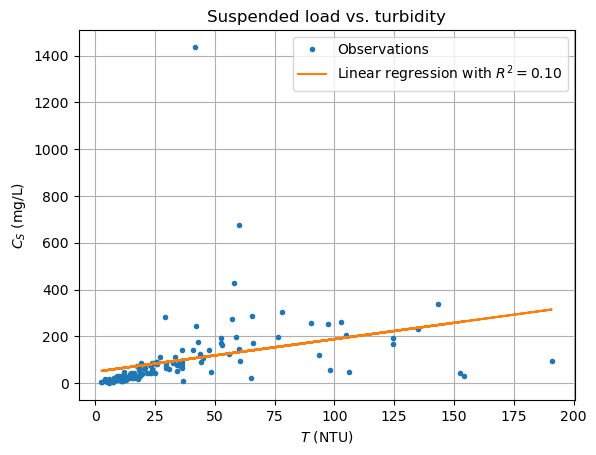

In [10]:
# Rename vectors
y = data["suspended_load"].to_numpy()
x = data["turbidity"].to_numpy()

# Reshape the vectors
y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Create a linear regression object
model_1 = linear_model.LinearRegression()

# Fit the model
model_1.fit(x, y)

# Get predictions
y_pred = model_1.predict(x)

# Plot the results
ax = data.plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    grid=True,
    xlabel="$T$ (NTU)",
    ylabel="$C_S$ (mg/L)",
    title="Suspended load vs. turbidity",
    label="Observations",
)

# Plot the linear regression
label = f"Linear regression with $R^2 = {model_1.score(x, y):.2f}$"
ax.plot(x, y_pred, label=label)

# Add the legend
ax.legend();

### 5.2. Robust linear regression

It is obvious that the linear regression struggles with outliers. Several solutions exist to deal with outliers. One of them is to use a robust linear regression, which performs the linear regression on a subset of the data and iteratively removes the outliers in a randomized way. The `scikit-learn` library provides a robust linear regression model. You can find more information about it in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html).

> __Question 8.__ Use the robust linear regression model to fit the data. What score do you obtain? How does it depend on the hyperparameters of the model? Do you think that splitting the data into a training and a testing set is useful here?
> 
> __Answer 8.__ The score obtained with the robust linear regression is 0.1, and the one obtained with a RANDSAC algorithm is 0.93 with an maximum outlier removal of 50%. The score depends on the hyperparameters of the model, namely the maximum number of samples kept as inliers. If we increase this number further than 50%, the score decreases (0.85 for 75%). Splitting the data into training and testing might not be useful here because it is not based on the same principle than outliers removal.

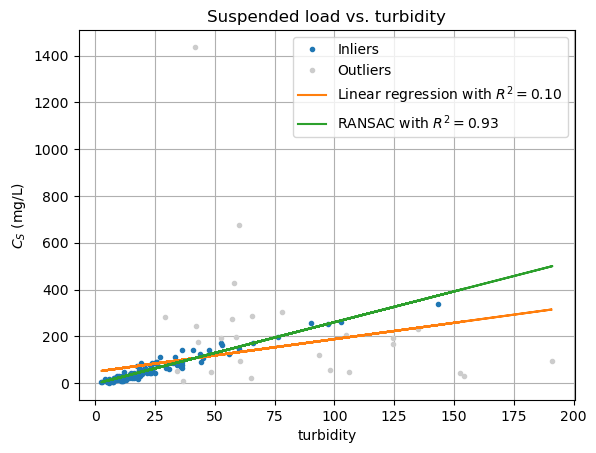

In [18]:
# Rename vectors
y = data["suspended_load"].to_numpy()
x = data["turbidity"].to_numpy()

# Reshape the vectors
y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Create a linear regression object
model_2 = linear_model.RANSACRegressor(min_samples=0.25)

# Fit the model
model_2.fit(x, y)

# Get the inliers
inliers = model_2.inlier_mask_

# Plot inliers
ax = data[inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    grid=True,
    xlabel="$T$ (NTU)",
    ylabel="$C_S$ (mg/L)",
    title="Suspended load vs. turbidity",
    label="Inliers",
)

# Plot outliers
data[~inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    ax=ax,
    label="Outliers",
    color="0.8",
)

# Plot the linear regression
label = f"Linear regression with $R^2 = {model_1.score(x, y):.2f}$"
ax.plot(x, model_1.predict(x), label=label)

# Plot the robust linear regression
label = f"RANSAC with $R^2 = {model_2.score(x[inliers], y[inliers]):.2f}$"
ax.plot(x, model_2.predict(x), label=label)

# Add the legend
ax.legend()
ax.grid(True)


### 5.3. Working in the log-log space

As you were told quite a lot in the lecture, the representation of the data is very important. As you can understand from the scatter matrix plot that we did in the data preparation section, the density of measurements in higher for lower values of the suspended load. This is a problem for the linear regression, since it will tend to fit the data in the low range of suspended load. One way to deal with this problem is to work in the log-log space.

> __Question 9.__ Make the inspection of the data in the log-log space. What do you observe? What is the score of the linear regression in the log-log space? What is the score of the robust linear regression in the log-log space? 
> 
> __Answer 9.__ In the log-log space we observe that the density of points is more uniform. The score of the linear regression in the log-log space is 0.61, and the RANDSAC algorithm gives a score of 0.85 with a maximum outlier removal of 50%. This indicates that making the regression in the log-log space is more efficient than in the original space, suggesting that we should learn to transform the data to make it more suitable for the model.

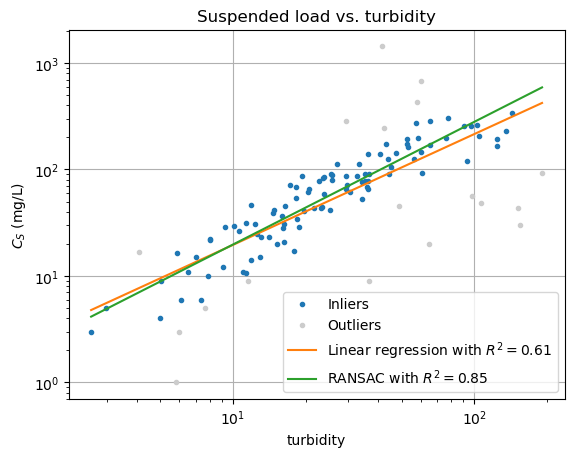

In [12]:
# Rename vectors
y = data["suspended_load"].to_numpy()
x = data["turbidity"].to_numpy()

# Reshape the vectors
y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Transform in the log space
y_log = np.log(y)
x_log = np.log(x)

# Create a linear regression object
model_3 = linear_model.LinearRegression()
model_4 = linear_model.RANSACRegressor(min_samples=0.5)

# Fit the model
model_3.fit(x_log, y_log)
model_4.fit(x_log, y_log)

# Get the inliers
inliers = model_4.inlier_mask_

# Plot inliers
ax = data[inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    grid=True,
    xlabel="$T$ (NTU)",
    ylabel="$C_S$ (mg/L)",
    title="Suspended load vs. turbidity",
    label="Inliers",
)

# Plot outliers
data[~inliers].plot(
    x="turbidity",
    y="suspended_load",
    style=".",
    ax=ax,
    label="Outliers",
    color="0.8",
)

x_range = np.linspace(x_log.min(), x_log.max(), 100).reshape(-1, 1)

# Plot the linear regression
label = f"Linear regression with $R^2 = {model_3.score(x_log, y_log):.2f}$"
ax.plot(np.exp(x_range), np.exp(model_3.predict(x_range)), label=label)

# Plot the robust linear regression
label = f"RANSAC with $R^2 = {model_3.score(x_log[inliers], y_log[inliers]):.2f}$"
ax.plot(np.exp(x_range), np.exp(model_4.predict(x_range)), label=label)

# Add the legend
ax.legend()
ax.grid(True)
ax.set_xscale("log")
ax.set_yscale("log")

### 5.4. Using a multivariate linear regression

We have seen that the water level is also correlated with the suspended load. It is therefore interesting to use it as an additional feature to predict the suspended load. This is called a multivariate linear regression. The `scikit-learn` library provides a multivariate linear regression model. You can find more information about it in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

> __Question 10.__ Use the multivariate linear regression model to fit the data. What score do you obtain? How does it depend on the hyperparameters of the model? 
> 
> __Answer 10.__ The score obtained with the multivariate linear regression is still low with a multivariate linear regression (0.1), but increases to 0.95 with a RANDSAC algorithm with a maximum outlier removal of 25%. This indicates that the water level is a relevant feature to predict the suspended load.

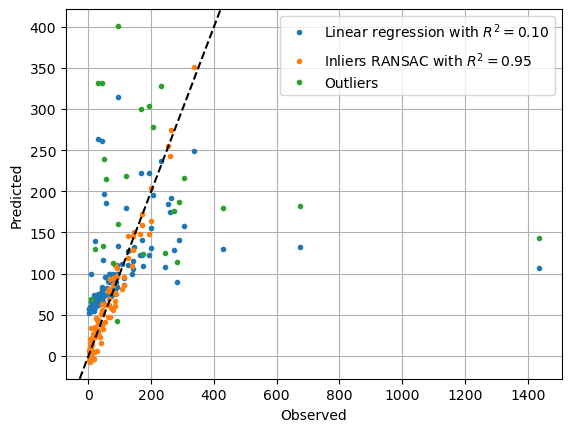

In [19]:
# Rename vectors
y = data["suspended_load"].to_numpy()
x_2 = data[["turbidity", "level"]].to_numpy()

# Reshape the vectors
y = y.reshape(-1, 1)

# Create a linear regression object and fit the model
model_5 = linear_model.RANSACRegressor(min_samples=0.25)
model_5.fit(x_2, y)

# Prepare the plot
fig, ax = plt.subplots()

# Plot the linear regression
label = f"Linear regression with $R^2 = {model_1.score(x, y):.2f}$"
ax.plot(y, model_1.predict(x), ".", label=label)

# Plot the robust linear regression
inliers = model_5.inlier_mask_
label = f"RANSAC with $R^2 = {model_5.score(x_2[inliers], y[inliers]):.2f}$"
ax.plot(y[inliers], model_5.predict(x_2[inliers]), ".", label=f"Inliers {label}")
ax.plot(y[~inliers], model_5.predict(x_2[~inliers]) , ".", label="Outliers")

# Add the legend
ax.axline((0, 0), slope=1, color="k", ls="--")
ax.legend()
ax.set_xlabel("Observed")
ax.set_ylabel("Predicted")
ax.grid(True)

### 5.5. Testing other models

Now we can use the `scikit-learn` library to test other models. You can find a list of the available models in the [documentation](https://scikit-learn.org/stable/supervised_learning.html). You can also find a list of the available metrics in the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics). This is a good opportunity to understand the concept of greybox. You can also use the `scikit-learn` [cheat sheet](https://scikit-learn.org/stable/machine_learning_map.html) to help you choose the right model.

![](https://scikit-learn.org/stable/_static/ml_map.png)

> __Question 11.__ Test other models and compare them. What is the best model, and why? Consider using a train-test split to answer this question. Argue your answer.
>
> __Answer 11.__ We test several regression algorithms (see below) and split the data into a training and testing set. The best model is the Random Forest Regressor, which gives a test score of 0.97. 

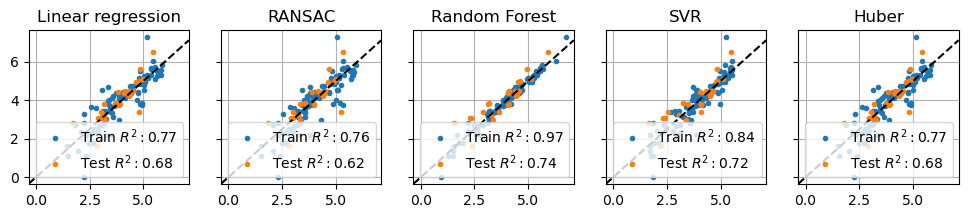

In [20]:
# Collect models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, RANSACRegressor, LinearRegression
from sklearn.model_selection import train_test_split

models = {
    "Linear regression": LinearRegression(),
    "RANSAC": RANSACRegressor(min_samples=0.5),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Huber": HuberRegressor(),
}

# Get the data
y = np.log(data["suspended_load"].to_numpy())
x = np.log(data[["turbidity", "level"]].to_numpy())

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Prepare the plot
fig, axes = plt.subplots(1, len(models), figsize=(12, 2), sharey=True, sharex=True)

# Loop over the models
for ax, (name, model) in zip(axes, models.items()):
    # Fit the model
    model.fit(x_train, y_train)

    # Get the score
    test_score = model.score(x_test, y_test)
    train_score = model.score(x_train, y_train)

    # Plot the results
    ax.plot(model.predict(x_train), y_train, ".", label=f"Train $R^2: {train_score:.2f}$")
    ax.plot(model.predict(x_test), y_test, ".", label=f"Test $R^2: {test_score:.2f}$")
    ax.axline((0, 0), slope=1, color="k", linestyle="--")
    ax.set_title(name)  
    ax.grid(True)
    ax.legend()

## 6. Use your model to predict the suspended load on a time period where no suspended load measurements are available

Now it's time to use your model to predict the suspended load on a time period where no suspended load measurements are available. Based on the model comparison you did in the previous section, choose the best model and train it on the whole dataset. Then, use it to predict the suspended load on the period from 2015-03-01 to 2015-05-01. 

> __Question 12.__ Plot the predicted suspended load and the measured suspended load on the same plot. What do you observe? What special patterns do observe in the predicted suspended load that you do not observe in the measured suspended load? Try to explain these patterns in your own words.
> 
> __Answer 12.__ The predicted suspended load shows sharp increases and slower decays, which is hard to observe on the measured suspended load. The sharp increase is likely due to sudden rain events, and the slow decay is likely due to the time it takes for the suspended load to be transported downstream. More information about the transport time of suspended load can be found in Roque-Bernard et al. ([2023](https://doi.org/10.5194/esurf-11-363-2023)).

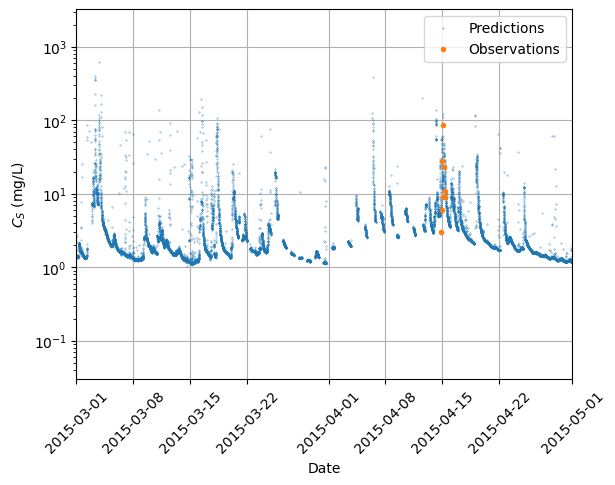

In [15]:
# Extract x from data_hydro before resampling
data_hydro_nona = data_hydro.dropna()
x_original_log = data_hydro_nona[["turbidity", "level"]].dropna().to_numpy()
x_original_log = np.log(x_original_log)

fig, ax = plt.subplots()
ax.plot(data_hydro_nona.index, np.exp(model.predict(x_original_log)), ".", ms=0.5, label="Predictions")
ax.plot(data.index, data["suspended_load"], ".", label="Observations")
ax.set_xlim(pd.to_datetime("2015-03-01"), pd.to_datetime("2015-05-01"))
ax.set_xlabel("Date")
ax.set_ylabel("$C_S$ (mg/L)")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.tick_params(axis="x", rotation=45)